<b><font size="6">Techscape Project</font><a class="anchor"><a id='toc'></a></b><br>

In [99]:
import pandas as pd
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

In [100]:
techscape = pd.read_csv('train.csv')
techscape.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,22-Dec-20,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,24-Nov-20,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


In [101]:
#techscape.Date.value_counts()


In [102]:
# No missing values
techscape.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   9999 non-null   int64  
 1   Date                        9999 non-null   object 
 2   AccountMng_Pages            9999 non-null   int64  
 3   AccountMng_Duration         9999 non-null   float64
 4   FAQ_Pages                   9999 non-null   int64  
 5   FAQ_Duration                9999 non-null   float64
 6   Product_Pages               9999 non-null   int64  
 7   Product_Duration            9999 non-null   float64
 8   GoogleAnalytics_BounceRate  9999 non-null   float64
 9   GoogleAnalytics_ExitRate    9999 non-null   float64
 10  GoogleAnalytics_PageValue   9999 non-null   float64
 11  OS                          9999 non-null   object 
 12  Browser                     9999 non-null   int64  
 13  Country                     9999 

In [103]:
# Change types of variables

# ID does not make sense to be a int
techscape.Access_ID = techscape.Access_ID.astype('string') 

# Tranform Date into a datetime format
techscape.Date = pd.to_datetime(techscape.Date)

techscape.OS = techscape.OS.astype('string') 


techscape.Country = techscape.Country.astype('string') 


techscape.Type_of_Visitor = techscape.Type_of_Visitor.astype('string') 

techscape.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Access_ID                   9999 non-null   string        
 1   Date                        9999 non-null   datetime64[ns]
 2   AccountMng_Pages            9999 non-null   int64         
 3   AccountMng_Duration         9999 non-null   float64       
 4   FAQ_Pages                   9999 non-null   int64         
 5   FAQ_Duration                9999 non-null   float64       
 6   Product_Pages               9999 non-null   int64         
 7   Product_Duration            9999 non-null   float64       
 8   GoogleAnalytics_BounceRate  9999 non-null   float64       
 9   GoogleAnalytics_ExitRate    9999 non-null   float64       
 10  GoogleAnalytics_PageValue   9999 non-null   float64       
 11  OS                          9999 non-null   string      

In [104]:
# Check for incoherencies in the data:

# Date variable
print(f'Date of the web visit varies from {techscape.Date.min()} and {techscape.Date.max()}, excluding the month of April.')


Date of the web visit varies from 2020-02-01 00:00:00 and 2020-12-31 00:00:00, excluding the month of April.


In [105]:
# Pages and Duration variables


#techscape[(techscape['AccountMng_Pages']==0) & (techscape['AccountMng_Duration']!=0) ] # --> 0
account_index = techscape[(techscape['AccountMng_Pages']>1) & (techscape['AccountMng_Duration']==0) ].index  # --> 3
len(account_index)
techscape.drop(account_index, axis=0, inplace=True)
techscape


#techscape[(techscape['FAQ_Pages']==0) & (techscape['FAQ_Duration']!=0) ] # --> 0
faq_index = techscape[(techscape['FAQ_Pages']>1) & (techscape['FAQ_Duration']==0) ].index # --> 9
len(faq_index)
techscape.drop(faq_index, axis=0, inplace=True)
techscape


#techscape[(techscape['Product_Pages']==0) & (techscape['Product_Duration']!=0) ] # --> 0
product_index = techscape[(techscape['Product_Pages']>1) & (techscape['Product_Duration']==0) ].index # --> 130
len(product_index)
techscape.drop(product_index, axis=0, inplace=True)
techscape

# Total removed = 3 + 9 + 130 = 142

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,2020-03-21,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,2020-05-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,2020-12-04,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,2020-12-22,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,2020-11-24,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,2020-05-08,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,0.0000,MacOSX,2,Brazil,14,Returner,0
9995,798314158,2020-07-17,6,175.1,0,0.0,3,27.6000,0.0000,0.0111,0.0000,Windows,10,Spain,5,New_Access,0
9996,798339820,2020-03-23,0,0.0,0,0.0,27,644.0000,0.0077,0.0519,0.0000,MacOSX,2,France,3,Returner,0
9997,798371242,2020-05-16,0,0.0,0,0.0,53,715.5000,0.0226,0.0363,0.0000,Windows,2,Italy,3,Returner,0


In [106]:

# Let's see if data has outliers --> we can remove a maximum of 3% (300 observations) 

techscape.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Access_ID,9857,9857,403617971,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,9857,305,2020-05-25 00:00:00,118,2020-02-01,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AccountMng_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,2.353454,3.352719,0.0,0.0,1.0,4.0,27.0
AccountMng_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,82.25781,180.712931,0.0,0.0,9.5,94.0,3398.75
FAQ_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,0.513442,1.28642,0.0,0.0,0.0,0.0,24.0
FAQ_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,35.05696,140.738449,0.0,0.0,0.0,0.0,2549.375
Product_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,32.069494,44.734139,0.0,8.0,18.0,38.0,705.0
Product_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,1215.786133,1967.220922,0.0,197.0,612.625,1483.55,63973.5222
GoogleAnalytics_BounceRate,9857.0,NaN,NaN,NaN,NaT,NaT,0.020057,0.044845,0.0,0.0,0.0029,0.016,0.2
GoogleAnalytics_ExitRate,9857.0,NaN,NaN,NaN,NaT,NaT,0.041122,0.045789,0.0,0.0142,0.025,0.0481,0.2


In [107]:
techscape[['AccountMng_Pages', 'FAQ_Pages', 'Product_Pages']].describe().T

# AccountMng_Pages appears to have outliers
# Same with FAQ_Pages
# Product_Pages definitely has outliers

,count,mean,std,min,25%,50%,75%,max
AccountMng_Pages,9857.0,2.353454,3.352719,0.0,0.0,1.0,4.0,27.0
FAQ_Pages,9857.0,0.513442,1.286420,0.0,0.0,0.0,0.0,24.0
Product_Pages,9857.0,32.069494,44.734139,0.0,8.0,18.0,38.0,705.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1ddc2306850>,
 'caps': [<matplotlib.lines.Line2D at 0x1ddc2306f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ddc23064f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1ddc245b610>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ddc245b970>],
 'means': []}

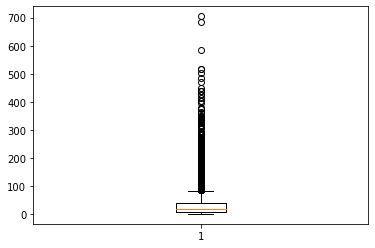

In [108]:
#plt.boxplot(x=techscape['AccountMng_Pages'])
#plt.boxplot(x=techscape['FAQ_Pages'])
plt.boxplot(x=techscape['Product_Pages'])

In [109]:
techscape[['AccountMng_Duration', 'FAQ_Duration', 'Product_Duration']].describe().T

# Same logic here

,count,mean,std,min,25%,50%,75%,max
AccountMng_Duration,9857.0,82.257810,180.712931,0.0,0.0,9.500,94.00,3398.7500
FAQ_Duration,9857.0,35.056960,140.738449,0.0,0.0,0.000,0.00,2549.3750
Product_Duration,9857.0,1215.786133,1967.220922,0.0,197.0,612.625,1483.55,63973.5222


In [110]:
techscape[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'Browser', 'Type_of_Traffic']].describe().T

# GoogleAnalytics_PageValue appear to have outliers

,count,mean,std,min,25%,50%,75%,max
GoogleAnalytics_BounceRate,9857.0,0.020057,0.044845,0.0,0.0000,0.0029,0.0160,0.2000
GoogleAnalytics_ExitRate,9857.0,0.041122,0.045789,0.0,0.0142,0.0250,0.0481,0.2000
GoogleAnalytics_PageValue,9857.0,6.046826,18.874397,0.0,0.0000,0.0000,0.0000,361.7637
Browser,9857.0,2.353556,1.716837,1.0,2.0000,2.0000,2.0000,13.0000
Type_of_Traffic,9857.0,3.937405,3.652248,1.0,2.0000,2.0000,4.0000,15.0000


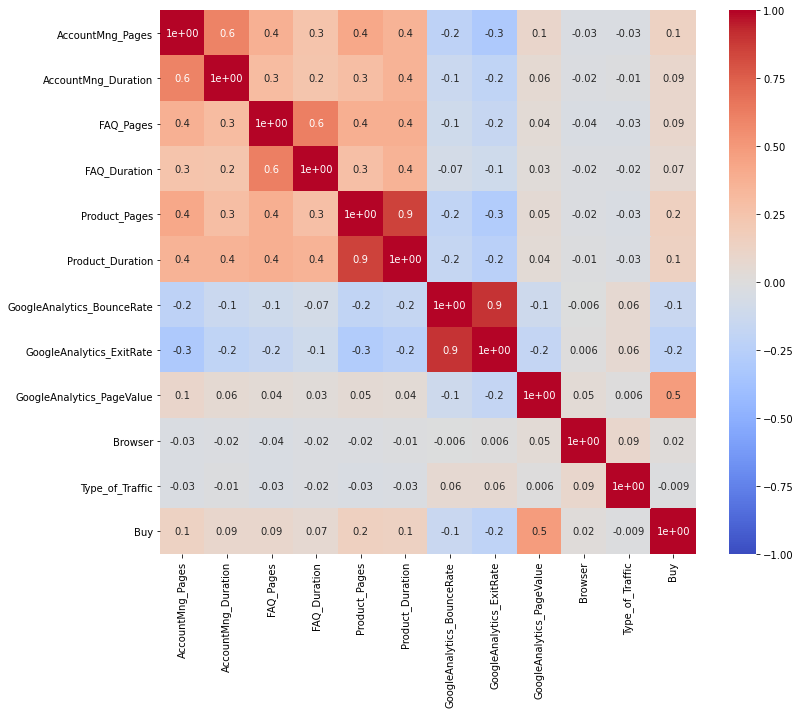

In [132]:


# Check Correlations:

corr = techscape.corr(method = 'pearson')

def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, vmin=-1, vmax=1, annot = True, cmap ="coolwarm" , fmt='.1')

    plt.show()

    
cor_heatmap(corr)    

In [112]:


# Chi-Square for categorical data

X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [113]:
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Access_ID is NOT an important predictor. (Discard Access_ID from model)
Date is IMPORTANT for Prediction
OS is IMPORTANT for Prediction
Country is NOT an important predictor. (Discard Country from model)
Type_of_Visitor is IMPORTANT for Prediction


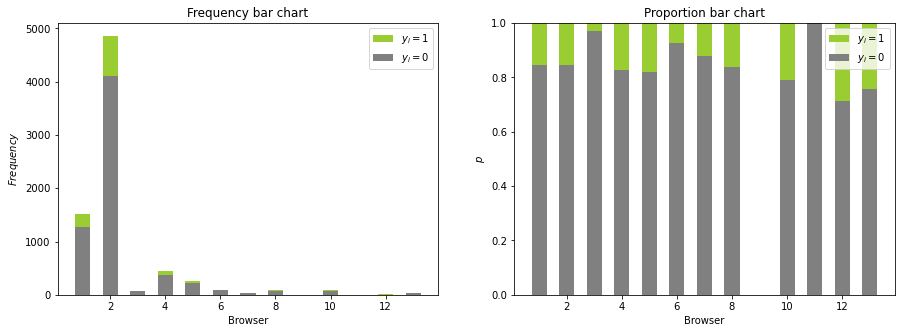

In [114]:


# Plot variables regarding the target variable

# first join all the training data
all_train = X_train.join(y_train)


def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    #plt.xticks()
    plt.show()
    
bar_charts_categorical(all_train, "Browser", "Buy")

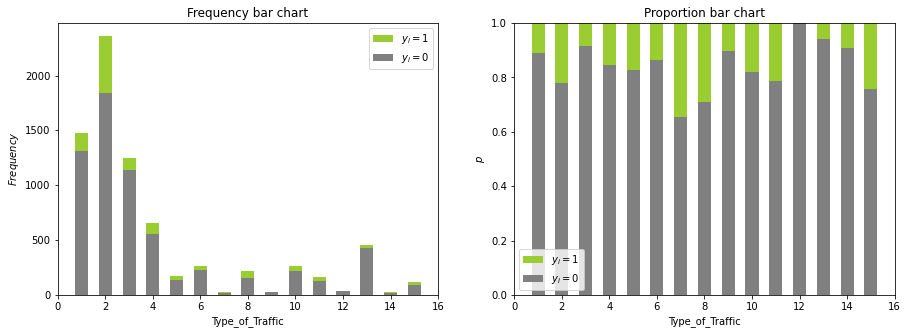

In [115]:
bar_charts_categorical(all_train, "Type_of_Traffic", "Buy")

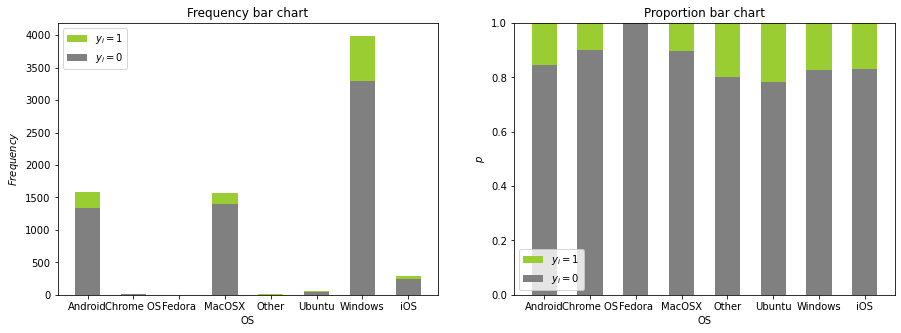

In [116]:
bar_charts_categorical(all_train, "OS", "Buy")

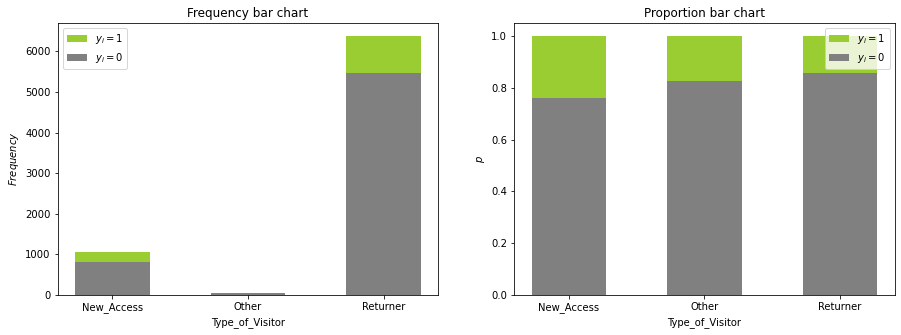

In [117]:
bar_charts_categorical(all_train, "Type_of_Visitor", "Buy")

In [11]:
# Define data as all the independent variables
data = techscape.drop(['Buy'], axis=1)
# Define target as the dependent variable
target = techscape['Buy']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, target, train_size=0.75, stratify = target, random_state=5)
# Train 0.75 || Valid 0.25
# Stratify so we have the same values in target in the train and val datasets